# Presentation

We are interested in the theme "Predicting a playlist that satisfies group members (e.g., to decide the music to play in a party).", from this theme, we define the following research questions :

## Research questions

- **How to determine a similarity metric among artists, given a list of user-artist-plays tuples?**
    - From users' listening patterns on the 360K dataset, generate features to decide if an artist is more liked than another (ex : listened much more than the user's average per-artist plays)
    - Using SVD or matrix factorization using the previous features, generate a similarity feature space with respect to users and artists
- **How to compute a set of recommended artist, given previous similarity metrics, and a set of known-liked artists ?**
    - Find clustering of artists given similarity metric
    - Multiple ideas for generating the set : 
        - Use the mean of top artists of our users to determine a "center point" => may not be great, given that SVD isn't required to create a feature space that makes sense when we try to get the center (try to please everyone but please no one)
        - Pick artists that are close to each user's center point, but tends to be slightly biased towards others (please each user one at a time)
    
- **From a set of artists, how to compute the best fitting playlist ?**
    - Using other datasets, such as spotify's dataset, sample top tracks from our selected artist
    - More in depth : same analysis as before, but finding a set of music tracks using the 1K Dataset instead of the 360K

## Datasets used

**1) Last.fm Dataset - 360K users (user top artists)**

This dataset contains <user, artist-mbid, artist-name, total-plays> tuples (for ~360,000 users) collected from Last.fm API, using the user.getTopArtists() method.


**2) Last.fm Dataset - 1K users (user full listening history)**

This dataset contains <user-id, timestamp, artist-mbid, artist-name, song-mbid, song-title> tuples collected from Last.fm API, using the user.getRecentTracks() method.
The dataset represents the full listening history (till May, 5th 2009) for nearly 1,000 users.

## Libraries used

We may want to use dask dataframes (pandas dataframes divided in multiple partitions) if the pandas one doesn't fit into memory.

In [1]:
import pandas as pd
import dask.dataframe as dd
import tarfile
from dask.delayed import delayed

# Coding

## Loading Data

Here we load the csv files into pandas dataframes

In [2]:
cols_1k   = ['userid','timestamp','musicbrainz-artist-id','artist-name','musicbrainz-track-id','track-name']
cols_360k = ['user-id','artist-id','artist-name','plays']

PATH_1k   = 'data/lastfm-dataset-1K.tar.gz'
PATH_360k = 'data/lastfm-dataset-360K.tar.gz'

PATH_1k_data   = 'lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv'
PATH_360k_data = 'lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'

with tarfile.open(PATH_1k, "r:*") as tar:
    df_1k = pd.read_csv(tar.extractfile(PATH_1k_data), sep="\t", error_bad_lines=False, header=0, names=cols_1k)

with tarfile.open(PATH_360k, "r:*") as tar:
    df_360k = pd.read_csv(tar.extractfile(PATH_360k_data), sep="\t", error_bad_lines=False, header=0, names=cols_360k)

## Exploratory Data analysis

### Data Cleaning

#### We keep only user-ids that are valid sha-1 hashes 

In [18]:
sha1_match = r'\b([a-f0-9]{40})\b'

df_360k = df_360k[df_360k['user-id'].str.fullmatch(sha1_match)]

#### We do the same, but this time for the artist ids (some are na by default, we just remove them as well) :

In [31]:
artist_match = r'\b([a-f0-9]{8})-([a-f0-9]{4})-([a-f0-9]{4})-([a-f0-9]{4})-([a-f0-9]{12})\b'

df_360k = df_360k[df_360k['artist-id'].str.fullmatch(artist_match, na=False)]

#### Just to be safe : let's check that we always have a positive amount of plays

In [42]:
(df_360k['plays'] <= 0).any()

False

#### We can now simply describe the dataset :

In [38]:
df_360k.describe()

,plays
count,1.730707e+07
mean,2.160583e+02
std,6.170583e+02
min,1.000000e+00
25%,3.500000e+01
50%,9.500000e+01
75%,2.250000e+02
max,4.191570e+05


After this simple cleaning, we still have around 17 million entries : this is nice because we have a lot of data, but we'll have to think about how to process it all efficiently. 

From this, we know that the mean number of plays is 216, but the std is quite high : at 617.

#### Since we dropped na artist ids, all those value are non na, what about other columns :

In [33]:
df_360k.isna().any()

user-id        False
artist-id      False
artist-name     True
plays          False
dtype: bool

In [43]:
df_360k['artist-name'].isna().value_counts()

False    17306872
True          202
Name: artist-name, dtype: int64

There's so few that we can probably remove artists with no name

In [44]:
df_360k = df_360k.dropna()

### Let's explore :

#### Let's find more information about the average users

In [54]:
per_user_sets = df_360k.groupby('user-id').agg(lambda x : set(x))

set_len = per_user_sets['artist-id'].apply(lambda x : len(x))

(set_len.mean(), set_len.std())

(48.226879305348106, 8.569585664633415)

We see that on average, people listen to around 48 artists, with a standard deviation of 8.5.

#### Now let's try the same, considering artists listened more than 50 times per user :

In [55]:
per_user_sets = df_360k[df_360k['plays'] > 50].groupby('user-id').agg(lambda x : set(x))

set_len = per_user_sets['artist-id'].apply(lambda x : len(x))

(set_len.mean(), set_len.std())

(34.66633220915675, 18.26807005903841)

As expected, the mean is lower, and the standard deviation is a good amount higher.

#### What about the distribution of plays ?

##### With respect to users

In [65]:
import matplotlib.pyplot as plt

[Text(0.5, 1.0, 'Distribution of the number of plays with respect to users'),
 Text(0.5, 0, 'Number of users'),
 Text(0, 0.5, 'Number of plays')]

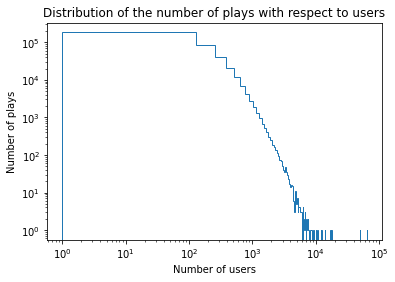

In [68]:
df_360k.groupby('user-id').mean()['plays'].plot(kind='hist', bins=500, logy=True, logx=True, histtype='step')
plt.gca().set(title='Distribution of the number of plays with respect to users', xlabel='Number of users', ylabel='Number of plays');

We see that a large majority of users have a number of plays under 1000, however we have no information about the time period, so it is hard to get more information than this, it's just something to keep in mind when we will be creating our features later : we should make sure to take into account the user's mean number of plays, rather than the global one, when we consider if a user likes an artist.

##### With respect to artists

<AxesSubplot:ylabel='Frequency'>

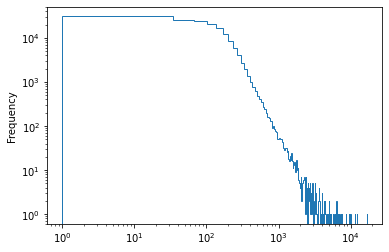

In [62]:
df_360k.groupby('artist-id').mean()['plays'].plot(kind='hist', bins=500, logy=True, logx=True, histtype='step')
plt.gca().set(title='Distribution of the number of plays with respect to artists', xlabel='Number of artists', ylabel='Number of plays')

Again, we see that most artists have a low number of plays, while some top artists are responsible for a larger amount.

For both graphs we have, we can't really say whether they follow a power-law or any real known distribution : from our log-log plot, there is no obvious shape, but we definitely need to keep in mind that particularity.

#### What are our top artists?

In [78]:
len(df_360k['artist-id'].unique())

160075

That's a lot of different artists !

#### What are our top artists?

In [75]:
top_artist_id = df_360k.groupby('artist-id').sum().sort_values(by='plays',ascending=False).head(5)

top_artist_id_names = top_artist_id.merge(df_360k,on='artist-id')['artist-name'].unique()

top_artist_id_names

array(['the beatles', 'beatles', 'beatles, the', 'radiohead', 'coldplay',
       'pink floyd', 'pink fluid', 'metallica'], dtype=object)

Those names are somewhat expected, but that shows that we have to make sure to use artist ids rather than names in the long run.